In [1]:
import numpy as np 
import pandas as pd 
import matplotlib # 
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn #   '''# means not necessary to run the code'''
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\azure\storage\blob\_encryption.py:19: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend


In [2]:
print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))


numpy: 1.18.3
pandas: 0.24.2
matplotlib: 3.2.1
seaborn: 0.10.1
sklearn: 0.22.1
MLFlow: 1.10.0


In [5]:
data_path = "D:\per\Codes\cloud_deployment\mlops\data\creditcard.csv\creditcard.csv"
df = pd.read_csv(data_path)

<>:1: DeprecationWarning: invalid escape sequence \p
<>:1: DeprecationWarning: invalid escape sequence \p
<>:1: DeprecationWarning: invalid escape sequence \p
<ipython-input-5-08a8367b5de2>:1: DeprecationWarning: invalid escape sequence \p
  data_path = "D:\per\Codes\cloud_deployment\mlops\data\creditcard.csv\creditcard.csv"


In [6]:
df = df.drop("Time", axis=1)

In [7]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
#Filtering the df values by class to create the normal and anomaly data frames. 
# -> Normal data contains 50% of all normal data pts, randomly selected as determined by the seed (random_state)
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [9]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


* There's still a big disparity in the data btn the normal and the anomaly points
* Though, Logistic Regression is still able to learn how to distinguish btn the two, it might be a problem for a neural network. However you can tell the model to weigh the anomalies far more in its learning process compared to the normal points. 

### Creating the train/test/validate split

* Following this split: 

    `x_train, x_test, y_train, y_test = train_test_split(x, y, test_
    size=0.2, random_state = 2020)`
            random_state is setting the random seed so that every 
            time you run it, the data will be split the same way.

In [8]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

Now, creating training and validation sets off of the training sets we have. 

In [9]:
normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

Creating the final training, testing, and validation sets - concatenate the resp normal and anomaly data splits. 


In [10]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

# Define y_train, y_test and y_validate
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

# Dropping 'Class' col in the x sets
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)


In [11]:
print("Training sets: \nx_train: {} y_train: {}".format(x_train.shape, y_train.shape))
print("\nTesting sets: \nx_test: {} y_test: {}".format(x_test.shape, y_test.shape))
print("\nValidation sets: \nx_validate: {} y_validate: {}".format(x_validate.shape, y_validate.shape))


Training sets: 
x_train: (85588, 30) y_train: (85588,)

Testing sets: 
x_test: (28531, 30) y_test: (28531,)

Validation sets: 
x_validate: (28531, 30) y_validate: (28531,)


The model would have a hard time optimizing the cost function and may take many more steps to converge if one don't scale the data. 

fitting the scaler on the entire dataset standardizes all of your data in the same way. Is to ensure the best result since you don't want to standardize x_train, x_test and x_validate in their own ways since it would create discrepancies in the data and be problematic for the model. 



In [12]:
scaler = StandardScaler()        #normalizes all the data with mean of 0 and std of 1
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

### Model Training

In [13]:
#define logistic regression model
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg').fit(x_train, y_train)

### Model Evaluation

In [14]:
eval_acc = sk_model.score(x_test, y_test)

In [15]:
#calculate the AUC score
preds = sk_model.predict(x_test)
auc_score = roc_auc_score(y_test, preds)

In [16]:
print(f"Auc Score: {auc_score:.3%}")
print(f"Eval Accuracy: {eval_acc:.3%}")

Auc Score: 84.331%
Eval Accuracy: 99.867%


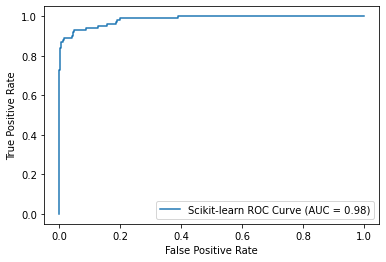

In [17]:
#figure which auc score is derived from
roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')

* The ROC Curve starting with a `true positive value` of 1.0 at a `false positive value` of 0.0 is the best possible curve in theory. 
* From that point, it should keep going right while maintaining its value as it hits 1.0 on the x-axis. 
* This graph is quite close to that ideal, hence why the AUC Score is so high at `0.98`. The discrepancy in AUC score here compared to when you calculated it earlier has to do with how the value is actually calculated. 

Text(0.5, 15.0, 'Predicted')

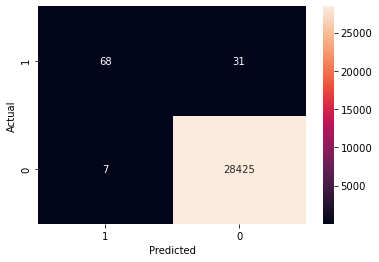

In [18]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
ax =sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()

plt.ylabel('Actual')
plt.xlabel('Predicted')

* The confusion matrix shows the lower AUC Score is `more accurate` at reflecting the true performance of the model. A non-negligible amount of anomalies were falsely classified as normal, hence an AUC score of `0.84` is a `much better indicator` of the model's performance than the graph's apparent score of `0.98`

* The row 1 on the `y-axis` has a sum of `99`: total number of anomalies in the test set. 
The model predicted about 68.7% of the anomalies correctly `(68/(68+31))` and predicted 99.98% of the normal points correctly `(28425/(28425+7))` looking at the bottom row. 
* Therefore, the `AUC score of 0.84` was much more accurate at indicating the performance of the model than the graph, which had an `AUC of 0.98`. It is expected that there are very few instances of false negatives or false positives with an `AUC OF 0.98`. 

### Model Validation 
* use of k-fold cross-validation to compare several hyperparameter values. 
* The `hyperparameter` to be `tuned` is how much one wants to `weight the anomalies` compared to the `normal data points`. By default both have equal weights. 

In [19]:
#Define list of weights to iterate over: 
anomaly_weights = [1, 5, 10, 15]

#define the number of folds and inititalize your data fold generator: 
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)


* constructing the KFold data generator with `five folds`, so the the data passed in will be split five ways. 

In [20]:
# Define the validation script:
logs = []

for f in range(len(anomaly_weights)): 
    fold = 1 
    accuracies = []
    auc_scores = [] 
    
    #goes over the 5 fold boundaries that KFold() object defines
    for train, test in kfold.split(x_validate, y_validate):
        weight = anomaly_weights[f]
        class_weights = {                   #set class_weights dict and pass it into the model as hyperparam
            0:1, 
            1: weight
        }
        sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg', 
                                      class_weight=class_weights).fit(x_validate[train], y_validate[train])
        

        for h in range(40): print('-', end="")
        print(f"\nfold {fold}\nAnomaly Weight: {weight}")

        eval_acc = sk_model.score(x_validate[test], y_validate[test])
        preds = sk_model.predict(x_validate[test])
        
        #try-except block for the AUC score in the event that fold generated only has values of one class
        #if the AUC score is -1 for any fold, then you know a problem occurred in one of the folds. 
        try: 
            auc_score = roc_auc_score(y_validate[test], preds)
        except: 
            auc_score = -1

        print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))

        accuracies.append(eval_acc)
        auc_scores.append(auc_score)
        
        #save model, validation data and the predictions data so as to examine the cm 
        #and plot the ROC Curve for any run one would prefer. 
        log = [sk_model, x_validate[test], y_validate[test], preds]
        logs.append(log)

        fold = fold + 1
    
    #after end of the 5 folds, the script displays AVERAGES and BEST scores
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
   
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
eval_acc: 0.9980722046968104
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages: 
Accuracy:  0.9985629653623302
AUC:  0.8391790849957024
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomal

* The  `best setup` in the validation is the one where `anomalies weighted as 10` since it has the best average AUC Score and the best AUC Score with the other anomaly weight parameters. 
* The `true best weight` is likely around an anomaly weight of 10, though you must perform another hyperparameter search with a more narrowed range to find the `absolute best setting`. 
* beware of diminishing returns past a certain precision. 

In [21]:
'''Since the anomaly 
weight was 10, and the second fold performed the best, you want to look at 
the twelfth index in the entries in logs. (The first five correspond to indices 
0-4, and the next five are indices 5-9. With index 10, you begin the first fold 
with weight ten, so the second fold is at index 11 '''
sk_model, x_val, y_val, preds = logs[11]

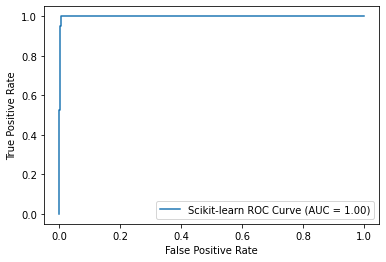

In [22]:
# calculate the ROC Curve
# AUC Score may not be so accurate given the little data in the validation set. 
roc_plot = plot_roc_curve(sk_model, x_val, y_val, name='Scikit-learn ROC Curve')

* ROC Curve for a specific validation fold: 
the ROC Curve is quite optimal. A perfect ROC Curve would start as close as possible to 1.0 on the y-axis while maintaining that level right as it reaches 1.0 on the x-axis. 

* An ROC Graph like that would mean the AUC would be as close to 1.0 as possible. In this case, you almost see the perfect AUC Curve, and the AUC is stated to be 1.0.

* Let's now get more info from the `confusion matrix`

Text(0.5, 15.0, 'Predicted')

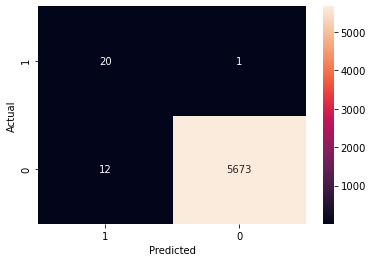

In [23]:
conf_matrix = confusion_matrix(y_val, preds)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()

plt.ylabel('Actual')
plt.xlabel('Predicted')

* The cm for a specific validation fold (12th). It has very good accuracy in labeling normal data points and does very well with anomaly points. 
* Additionally, you can see that there are barely any anomalies in the validation fold if you count the entries in the `top row: 21 anomalies to 5,685 normal points`. 
* No wonder, then, that having a higher weight on the anomaly helped the model factor in these anomalies in its learning process, resulting in better performance in anomaly detection. 